In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.integrate
from matplotlib import cm
from scipy import fft
from matplotlib.animation import FuncAnimation, PillowWriter 
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

In [7]:
alpha = .95
epsilon = .3
L = 2*np.pi
Ma = 0.
vol = 0.0001
I_0 = 10
remainder = Ma/I_0**2


In [8]:
def RHS_system(t,y):
    dydt = np.zeros_like(y)
    I = y[-1]
    dydt[-1] = vol*np.random.normal()
    #print(dydt[-1])
    Ma = remainder*I**2
    eta = y[:-1]
    N = len(eta)
    n = np.arange(N);
    n[int(N/2)+1:] -= N
    eta_z = fft.ifft(n*1j*np.pi*2/L*fft.fft(eta))
    eta_zzz = fft.ifft((n*1j*np.pi*2/L)**3*fft.fft(eta))
    detadt = -fft.ifft(n*1j*2*np.pi/L*fft.fft(eta**3*(1+(1-2*Ma)*eta_z+epsilon**2*eta_zzz))).real/3
    dydt[:-1] = detadt
    #print(dydt)
    return dydt

In [9]:
def RHS_not_stoch(time,eta):
    N = len(eta)
    n = np.arange(N);
    n[int(N/2)+1:] -= N
    eta_z = fft.ifft(n*1j*np.pi*2/L*fft.fft(eta))
    eta_zzz = fft.ifft((n*1j*np.pi*2/L)**3*fft.fft(eta))
    detadt = -fft.ifft(n*1j*2*np.pi/L*fft.fft(eta**3*(1+(1-2*Ma)*eta_z+epsilon**2*eta_zzz))).real/3
    return detadt

$$\eta_t +1/3\frac{\partial}{\partial z}(\eta^3(1+(1-2Ma)\eta_z+\epsilon^2 \eta_{zzz}))=0$$
$$ Ma = cte * I^2$$
$$Ma = cte*(I_0+\delta W_t)^2\approx Ma_0 + cte*\delta W_t + \mathcal{O}(\delta^2)$$

7
Solved deterministic , (256, 300)
Solved stoch, (256, 300)


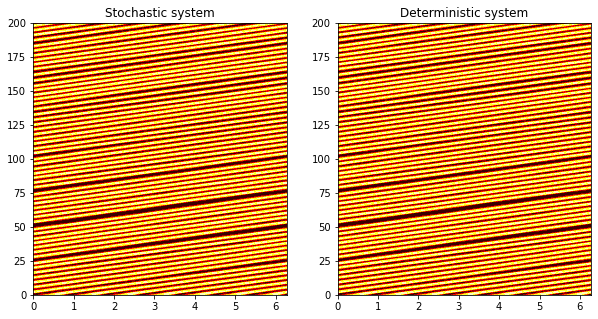

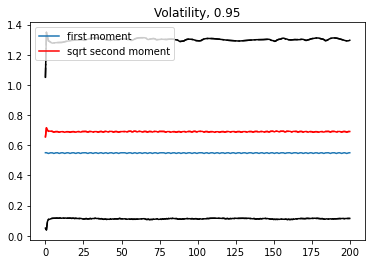

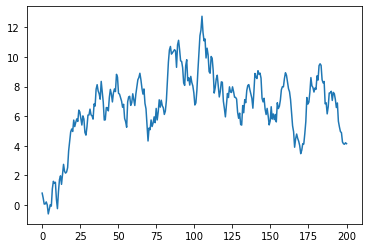

In [11]:
alpha = .95; epsilon = .1; L = 2*np.pi; Ma = 0.5; vol = 0.95; I_0 = 1; remainder = Ma/I_0**2; N=256
T = 200
k = round(1/np.sqrt(2)/epsilon)
print(k)
z = np.linspace(0, 2*np.pi, N)
t = np.linspace(0,T, 300)
delta_t = t[1]-t[0]
t_span = (0,T)
u0 = (1.1 - np.cos(z*k))/2 

N = len(u0)
n = np.arange(N);
n[int(N/2)+1:] -= N
def RHS_not_stoch(time,eta):

    eta_z = fft.ifft(n*1j*np.pi*2/L*fft.fft(eta))
    eta_zzz = fft.ifft((n*1j*np.pi*2/L)**3*fft.fft(eta))
    detadt = -fft.ifft(n*1j*2*np.pi/L*fft.fft(eta**3*(1+(1-2*Ma)*eta_z+epsilon**2*eta_zzz))).real/3
    return detadt


result_ivp_determininistic = scipy.integrate.solve_ivp(RHS_not_stoch, t_span, u0, 'BDF', atol = 1e-9, t_eval =t)

u_det = result_ivp_determininistic.y
print('Solved deterministic ,', np.shape(u_det))


#generate the Brownian Motion for the current 
I_t = np.cumsum(np.random.normal(loc=0.0, scale = vol*delta_t, size=(len(t), ))) + I_0

def RHS_no_current(time,eta):
    I = np.interp(time, t,I_t)
    Ma = remainder*I**2
    #print(Ma)
    N = len(eta)
    n = np.arange(N);
    n[int(N/2)+1:] -= N
    eta_z = fft.ifft(n*1j*np.pi*2/L*fft.fft(eta))
    eta_zzz = fft.ifft((n*1j*np.pi*2/L)**3*fft.fft(eta))
    detadt = -fft.ifft(n*1j*2*np.pi/L*fft.fft(eta**3*(1+(1-2*Ma)*eta_z+epsilon**2*eta_zzz))).real/3
    return detadt

result_ivp = scipy.integrate.solve_ivp(RHS_no_current, t_span, u0, 'BDF', atol = 1e-9, t_eval =t)
u = result_ivp.y
print('Solved stoch,', np.shape(u))


fig, ax=plt.subplots(nrows=1, ncols = 2, figsize = (10,5))
Z,T = np.meshgrid(z,t)
ax[0].contourf(Z,T,u.T, cmap ='hot')
ax[0].set_title('Stochastic system')
ax[1].contourf(Z,T,u_det.T, cmap ='hot')
ax[1].set_title('Deterministic system')
plt.savefig('stoch_realization.jpg')
#plt.colorbar()
plt.show()
plt.plot(t, np.max(u, axis = 0), color ='black'); plt.plot(t, np.min(u, axis = 0), color ='black')
plt.plot(t, np.max(u_det, axis = 0),'-.', color ='black'); plt.plot(t, np.min(u_det, axis = 0),'-.', color ='black')
plt.plot(t, np.trapz(u,z, axis = 0)/2/np.pi, label= 'first moment')
plt.plot(t, np.sqrt(np.trapz(u**2,z, axis = 0)/2/np.pi), label='sqrt second moment', color ='red')
plt.plot(t, np.sqrt(np.trapz(u_det**2,z, axis = 0)/2/np.pi),'-.', color ='red')
plt.legend()
plt.title(f'Volatility, {vol}')

plt.show()
plt.plot(t,I_t)

## Observations
$I$ modifies the Magnetic Bond $Ma$ number, which is affine to second order (Laplacian) diffusion. Thus, increasing I will make the system more stable, and decreasing I will make it more unstable.

Hence by having a stochastic I what we see is that the system is relaxed/excited randomly. 

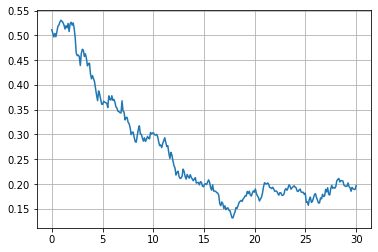

In [182]:
plt.plot(t, remainder*I_t**2)
plt.grid()

# Getting average behaviour and variances
What is a good metric to track and compute the prob distribution? Options:

1. Computing the maximum value at the end of the time evolution
2. Fit some kind of exponential to the data (max value) and check the growth parameter
2. Some kind of average, but this does not make much sense as the mass is conserved anyways, perhaps a more appropiate measure is computing the "variance of the profile" or some kind of second moment
3. Studying the stochastic profile - deterministic profile. In here, again we can look at the maximum value, if > 0 it means stochasticity is an unsteady actor, if < 0 it means it is a steadying actor. In here it still does not make sense to the average value as by linearity we expect it to be = 0, and its second moment might be interesting. 


All of our study is with Ma=0.5, so just at the bifurcation point, and starting with a planar wavefront with the most unstable wavelength according to linear theory

# Maximum value

In [46]:
#definitions: 
alpha = .95; epsilon = .3; L = 2*np.pi; Ma = 0.5; vol = 0.1; I_0 = 1; remainder = Ma/I_0**2

def RHS_not_stoch(time,eta):
    N = len(eta)
    n = np.arange(N);
    n[int(N/2)+1:] -= N
    eta_z = fft.ifft(n*1j*np.pi*2/L*fft.fft(eta))
    eta_zzz = fft.ifft((n*1j*np.pi*2/L)**3*fft.fft(eta))
    detadt = -fft.ifft(n*1j*2*np.pi/L*fft.fft(eta**3*(1+(1-2*Ma)*eta_z+epsilon**2*eta_zzz))).real/3
    return detadt

T = 30
k = 1/np.sqrt(2)/epsilon
print(k)
z = np.linspace(0, 2*np.pi, 200)
t = np.linspace(0,T, 300)
t_eval = np.linspace(0,T, 10)
delta_t = t[1]-t[0]

t_span = (0,T)
u0 = (1.1 - np.cos(z*k))/2 
result_ivp_determininistic = scipy.integrate.solve_ivp(RHS_not_stoch, t_span, u0, 'BDF', atol = 1e-9, t_eval =t)

u_det = result_ivp_determininistic.y
print('Solved deterministic ,', np.shape(u_det))
max_value_deterministic = np.max(u_det, axis=0)[-1]

2.3570226039551585
Solved deterministic , (200, 300)


In [26]:
Number_of_iter = 512

max_values = np.zeros(Number_of_iter)
mean_current = np.zeros(Number_of_iter)

for j in range(Number_of_iter):
    #generate the Brownian Motion for the current 
    I_t = np.cumsum(np.random.normal(loc=0.0, scale = vol*delta_t, size=(len(t), ))) + I_0
    
    mean_current[j] = np.mean(I_t)
    def RHS_no_current(time,eta):
        I = np.interp(time, t,I_t)
        Ma = remainder*I**2
        N = len(eta)
        n = np.arange(N);
        n[int(N/2)+1:] -= N
        eta_z = fft.ifft(n*1j*np.pi*2/L*fft.fft(eta))
        eta_zzz = fft.ifft((n*1j*np.pi*2/L)**3*fft.fft(eta))
        detadt = -fft.ifft(n*1j*2*np.pi/L*fft.fft(eta**3*(1+(1-2*Ma)*eta_z+epsilon**2*eta_zzz))).real/3
        return detadt

    result_ivp = scipy.integrate.solve_ivp(RHS_no_current, t_span, u0, 'BDF', atol = 1e-7, t_eval = t_eval)
    max_values[j] = np.max(result_ivp.y, axis = 0)[-1]
    
    
    if (j+1) % 10 == 0:
        print('Solved stoch,', np.shape(result_ivp.y), int(100*(j+1)/Number_of_iter), ' %')
    del I_t
    del RHS_no_current
    del result_ivp
    

Solved stoch, (200, 10) 2  %
Solved stoch, (200, 10) 4  %
Solved stoch, (200, 10) 6  %
Solved stoch, (200, 10) 8  %
Solved stoch, (200, 10) 10  %
Solved stoch, (200, 10) 12  %
Solved stoch, (200, 10) 14  %
Solved stoch, (200, 10) 16  %
Solved stoch, (200, 10) 18  %
Solved stoch, (200, 10) 20  %
Solved stoch, (200, 10) 22  %
Solved stoch, (200, 10) 24  %
Solved stoch, (200, 10) 26  %
Solved stoch, (200, 10) 28  %
Solved stoch, (200, 10) 30  %
Solved stoch, (200, 10) 32  %
Solved stoch, (200, 10) 34  %
Solved stoch, (200, 10) 36  %
Solved stoch, (200, 10) 38  %
Solved stoch, (200, 10) 40  %
Solved stoch, (200, 10) 42  %
Solved stoch, (200, 10) 44  %
Solved stoch, (200, 10) 46  %
Solved stoch, (200, 10) 48  %
Solved stoch, (200, 10) 50  %
Solved stoch, (200, 10) 52  %
Solved stoch, (200, 10) 54  %
Solved stoch, (200, 10) 56  %
Solved stoch, (200, 10) 58  %
Solved stoch, (200, 10) 60  %
Solved stoch, (200, 10) 62  %
Solved stoch, (200, 10) 64  %
Solved stoch, (200, 10) 66  %
Solved stoch, 

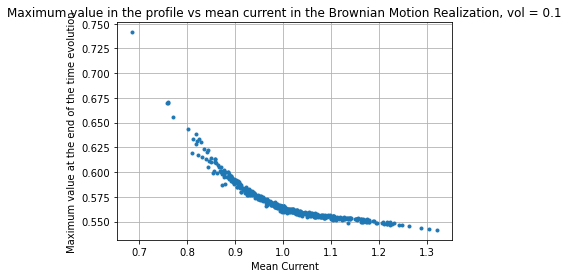

In [27]:
plt.plot(mean_current, max_values, '.')
plt.scatter(1, max_value_deterministic)
plt.grid()
plt.title(f'Maximum value in the profile vs mean current in the Brownian Motion Realization, vol = {vol}')
plt.xlabel('Mean Current')
plt.ylabel('Maximum value at the end of the time evolution')
plt.savefig('stoch_max_vs_mean_current.jpg')

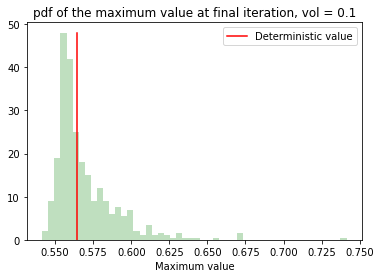

In [28]:
n, bins, patches = plt.hist(max_values,50, density = True, facecolor = 'green', alpha=0.25)
plt.plot(max_value_deterministic*np.ones_like(n), np.linspace(0,max(n), len(n)),
         color ='red', label = 'Deterministic value')
plt.xlabel('Maximum value')
plt.title(f'pdf of the maximum value at final iteration, vol = {vol}')
plt.legend()
plt.savefig('pdf_max_value_final_iteration.jpg')
plt.show()


In [29]:
np.trapz(n)*(bins[2]-bins[1]) #pdf check

0.9949999999999964

In [37]:
import pandas as pd
#np.savetxt("max_values_jan_17.csv", max_values, delimiter=",")
#np.savetxt("mean_currents_jan_17.csv", mean_current, delimiter=",")

pd.DataFrame([max_values, mean_current]).T.rename(columns={0:'max', 1:'current'}).to_csv('stoch_data_jan17.csv', index=False)
pd.read_csv('stoch_data_jan17.csv')

,max,current
0,0.557288,1.048821
1,0.561608,1.025887
2,0.560551,0.993576
3,0.579941,0.925187
4,0.576738,0.927726
...,...,...
495,0.557206,1.055615
496,0.541508,1.319440
497,0.578369,0.934619
498,0.553838,1.106787


# What I see
From this it is clear several things are taking place:
1. There is a maximum decay speed. (I find this odd)
2. A few outliers can really increase the maximum value i.e. the instability of the system. This might be related to escape probabilities?

# Parallelized Code

Number_of_iter = 2
def one_iteration(item):
    I_t = item
    mean_I = np.mean(I_t)
    def RHS_no_current(time,eta):
        I = np.interp(time, t,I_t)
        Ma = remainder*I**2
        N = len(eta)
        n = np.arange(N);
        n[int(N/2)+1:] -= N
        eta_z = fft.ifft(n*1j*np.pi*2/L*fft.fft(eta))
        eta_zzz = fft.ifft((n*1j*np.pi*2/L)**3*fft.fft(eta))
        detadt = -fft.ifft(n*1j*2*np.pi/L*fft.fft(eta**3*(1+(1-2*Ma)*eta_z+epsilon**2*eta_zzz))).real/3
        return detadt

    result_ivp = scipy.integrate.solve_ivp(RHS_no_current, t_span, u0, 'BDF', atol = 1e-7, t_eval = t_eval)
    max_value = np.max(result_ivp.y, axis = 0)[-1]
    #print(max_value)
    return max_value
items = [np.cumsum(np.random.normal(loc=0.0, scale = vol*delta_t, 
                                    size=(len(t), ))) + I_0 for j in range(Number_of_iter)]
mean_currents = np.mean(np.array(items), axis=1)
mean_currents

In [38]:
from concurrent.futures import ThreadPoolExecutor
Number_of_iter = 512
def iterate(j):
    I_t = np.cumsum(np.random.normal(loc=0.0, scale = vol*delta_t, size=(len(t), ))) + I_0
    mean_current_p[j] = np.mean(I_t)
    def RHS_no_current(time,eta):
        I = np.interp(time, t,I_t)
        Ma = remainder*I**2
        N = len(eta)
        n = np.arange(N);
        n[int(N/2)+1:] -= N
        eta_z = fft.ifft(n*1j*np.pi*2/L*fft.fft(eta))
        eta_zzz = fft.ifft((n*1j*np.pi*2/L)**3*fft.fft(eta))
        detadt = -fft.ifft(n*1j*2*np.pi/L*fft.fft(eta**3*(1+(1-2*Ma)*eta_z+epsilon**2*eta_zzz))).real/3
        return detadt

    result_ivp = scipy.integrate.solve_ivp(RHS_no_current, t_span, u0, 'BDF', atol = 1e-7, t_eval = t_eval)
    max_values_p[j] = np.max(result_ivp.y, axis = 0)[-1]
    del I_t
    del RHS_no_current
    del result_ivp
    #if (j+1) % 10 == 0:
     #   print('Solved stoch,', np.shape(result_ivp.y), int(100*(j+1)/Number_of_iter), ' %')
        
max_values_p = np.zeros(Number_of_iter)
mean_current_p = np.zeros(Number_of_iter)
with ThreadPoolExecutor(max_workers=2) as executor:
    results = executor.map(iterate, range(Number_of_iter))
print('finished solving stochastic')

finished solving stochastic


In [40]:
pd.DataFrame([max_values_p, mean_current_p]).T.rename(columns={0:'max', 1:'current'}).to_csv('stoch_data_para_jan17.csv', index=False)
pd.read_csv('stoch_data_para_jan17.csv')

,max,current
0,0.562844,0.999484
1,0.572046,0.950381
2,0.558989,1.031099
3,0.552096,1.135258
4,0.559069,1.037682
...,...,...
507,0.541008,1.316250
508,0.565514,0.998418
509,0.558289,1.037551
510,0.567415,0.989244


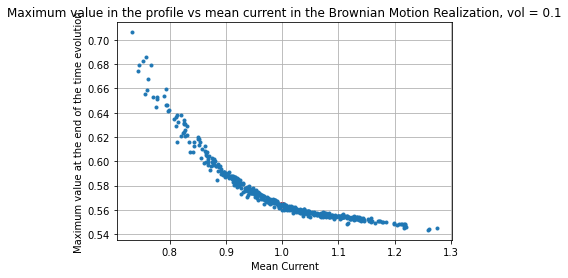

In [14]:
plt.plot(mean_current_p, max_values_p, '.')
plt.scatter(1, max_value_deterministic, color = 'red')
plt.grid()
plt.title(f'Maximum value in the profile vs mean current in the Brownian Motion Realization, vol = {vol}')
plt.xlabel('Mean Current')
plt.ylabel('Maximum value at the end of the time evolution')
plt.savefig('stoch_max_vs_mean_current_parallel.jpg')

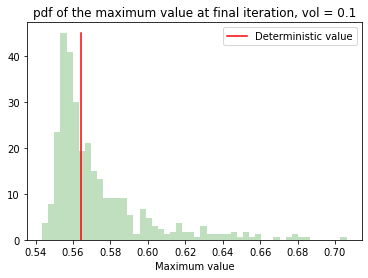

In [18]:
n, bins, patches = plt.hist(max_values_p,50, density = True, facecolor = 'green', alpha=0.25)
plt.plot(max_value_deterministic*np.ones_like(n), np.linspace(0,max(n), len(n)),
         color ='red', label = 'Deterministic value')
plt.xlabel('Maximum value')
plt.title(f'pdf of the maximum value at final iteration, vol = {vol}')
plt.legend()
plt.savefig('pdf_max_value_final_iteration_parallel.jpg')
plt.show()

import dask

delayed_results = [dask.delayed(iterate)(j) for j in range(Number_of_iter)]
results = dask.compute(*delayed_results)


7
Starting solve
Solved deterministic , (200, 300)
Solved stoch, (200, 300)


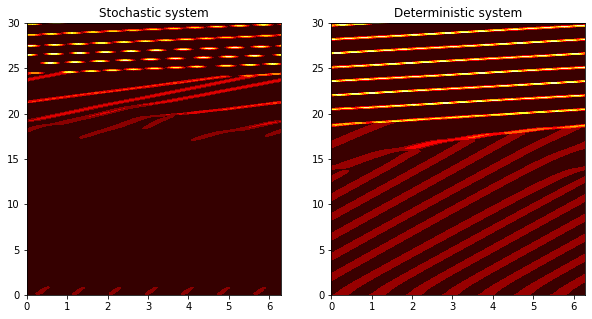

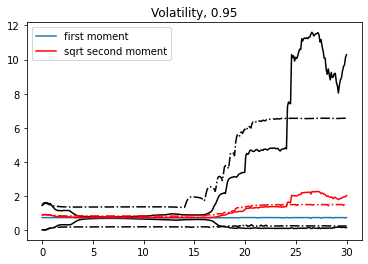

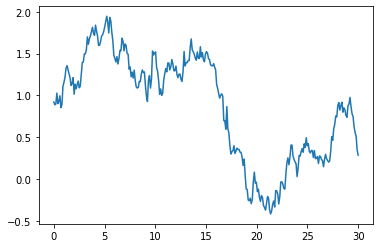

In [15]:
D = 0.6
alpha = .95; epsilon = .1; L = 2*np.pi; Ma = (1-D)/2; vol = 0.95; I_0 = 1; remainder = Ma/I_0**2; N=200

n = np.arange(N);
n[int(N/2)+1:] -= N
def RHS_not_stoch(time,eta):

    eta_z = fft.ifft(n*1j*np.pi*2/L*fft.fft(eta))
    eta_zzz = fft.ifft((n*1j*np.pi*2/L)**3*fft.fft(eta))
    detadt = -fft.ifft(n*1j*2*np.pi/L*fft.fft(eta**3*(1+(1-2*Ma)*eta_z+epsilon**2*eta_zzz))).real/3
    return detadt

T = 30
k = round(1/np.sqrt(2)/epsilon)
print(k)
z = np.linspace(0, 2*np.pi, N)
t = np.linspace(0,T, 300)
delta_t = t[1]-t[0]
t_span = (0,T)
u0 = (1 + np.sin(z*k)*0.95)*(1-alpha)*15
print('Starting solve')
result_ivp_determininistic = scipy.integrate.solve_ivp(RHS_not_stoch, t_span, u0, 'BDF', atol = 1e-9, t_eval =t)

u_det = result_ivp_determininistic.y
print('Solved deterministic ,', np.shape(u_det))


#generate the Brownian Motion for the current 
I_t = np.cumsum(np.random.normal(loc=0.0, scale = vol*delta_t, size=(len(t), ))) + I_0

def RHS_no_current(time,eta):
    I = np.interp(time, t,I_t)
    Ma = remainder*I**2
    #print(Ma)
    eta_z = fft.ifft(n*1j*np.pi*2/L*fft.fft(eta))
    eta_zzz = fft.ifft((n*1j*np.pi*2/L)**3*fft.fft(eta))
    detadt = -fft.ifft(n*1j*2*np.pi/L*fft.fft(eta**3*(1+(1-2*Ma)*eta_z+epsilon**2*eta_zzz))).real/3
    return detadt

result_ivp = scipy.integrate.solve_ivp(RHS_no_current, t_span, u0, 'BDF', atol = 1e-9, t_eval =t)
u = result_ivp.y
print('Solved stoch,', np.shape(u))


fig, ax=plt.subplots(nrows=1, ncols = 2, figsize = (10,5))
Z,T = np.meshgrid(z,t)
ax[0].contourf(Z,T,u.T, cmap ='hot')
ax[0].set_title('Stochastic system')
ax[1].contourf(Z,T,u_det.T, cmap ='hot')
ax[1].set_title('Deterministic system')
plt.savefig('stoch_realization_soliton.jpg')
#plt.colorbar()
plt.show()
plt.plot(t, np.max(u, axis = 0), color ='black'); plt.plot(t, np.min(u, axis = 0), color ='black')
plt.plot(t, np.max(u_det, axis = 0),'-.', color ='black'); plt.plot(t, np.min(u_det, axis = 0),'-.', color ='black')
plt.plot(t, np.trapz(u,z, axis = 0)/2/np.pi, label= 'first moment')
plt.plot(t, np.sqrt(np.trapz(u**2,z, axis = 0)/2/np.pi), label='sqrt second moment', color ='red')
plt.plot(t, np.sqrt(np.trapz(u_det**2,z, axis = 0)/2/np.pi),'-.', color ='red')
plt.legend()
plt.title(f'Volatility, {vol}')

plt.show()
plt.plot(t,I_t)